#### Image Dataset

In [17]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

Found 4 files belonging to 2 classes.
(1, 128, 128, 3) (1,)
(1, 128, 128, 3) (1,)
(1, 128, 128, 3) (1,)
(1, 128, 128, 3) (1,)
(128, 128, 3)


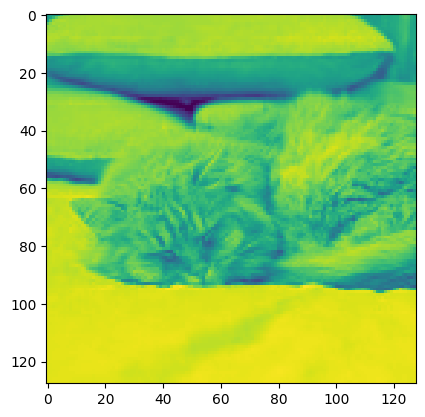

In [69]:
# Create a dataset.
dataset = keras.utils.image_dataset_from_directory(
  '/content/train_data', batch_size=1, image_size=(128, 128))

# For demonstration, iterate over the batches yielded by the dataset.
for data, labels in dataset:
  print(data.shape, labels.shape)


# plt.imshow(data[])
img = data[0]

print(img.shape)
plt.imshow(img[:, :, -3], interpolation='nearest')

### Text Dataset

In [97]:
from tensorflow.keras.layers import TextVectorization
import numpy as np

# Example training data, of dtype `string`.
training_data = np.array([["This is the 1st sample."], ["And here's the 2nd sample."]])

# Create a TextVectorization layer instance. It can be configured to either
# return integer token indices, or a dense token representation (e.g. multi-hot
# or TF-IDF). The text standardization and text splitting algorithms are fully
# configurable.
# vectorizer = TextVectorization(output_mode="int")
vectorizer = TextVectorization(output_mode="binary", ngrams=2)
# vectorizer = TextVectorization(output_mode="tf-idf")

vectorizer

In [98]:
# Calling `adapt` on an array or dataset makes the layer generate a vocabulary
# index for the data, which can then be reused when seeing new data.
vectorizer.adapt(training_data)
vectorizer

In [99]:
# After calling adapt, the layer is able to encode any n-gram it has seen before
# in the `adapt()` data. Unknown n-grams are encoded via an "out-of-vocabulary"
# token.
integer_data = vectorizer(training_data)
print(integer_data)

tf.Tensor(
[[0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]], shape=(2, 23), dtype=float32)


### Normalization

In [108]:
from tensorflow.keras.layers import Normalization

# Example image data, with values in the [0, 255] range
training_data = np.random.randint(0, 256, size=(64, 200, 200, 3)).astype("float32")

normalizer = Normalization(axis=-1)
normalizer.adapt(training_data)

normalized_data = normalizer(training_data)
print("var: %.4f" % np.var(normalized_data))
print("mean: %.4f" % np.mean(normalized_data))

var: 1.0006
mean: 0.0000


### rescaling & center-cropping images

In [109]:
from tensorflow.keras.layers import CenterCrop
from tensorflow.keras.layers import Rescaling

# Example image data, with values in the [0, 255] range
training_data = np.random.randint(0, 256, size=(64, 200, 200, 3)).astype("float32")

cropper = CenterCrop(height=150, width=150)
scaler = Rescaling(scale=1.0 / 255)

output_data = scaler(cropper(training_data))
print("shape:", output_data.shape)
print("min:", np.min(output_data))
print("max:", np.max(output_data))

shape: (64, 150, 150, 3)
min: 0.0
max: 1.0


### Functional API

In [116]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input

inputs = keras.Input(shape=(None, None, 3))

# Center-crop images to 150x150
x = CenterCrop(height=150, width=150)(inputs)
# Rescale images to [0, 1]
x = Rescaling(scale=1.0 / 255)(x)

# Apply some convolution and pooling layers
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3, 3))(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3, 3))(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)

# Apply global average pooling to get flat feature vectors
x = layers.GlobalAveragePooling2D()(x)

# Add a dense classifier on top
num_classes = 10
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

data = np.random.randint(0, 256, size=(64, 200, 200, 3)).astype("float32")
processed_data = model(data)
print(processed_data.shape)

(64, 10)


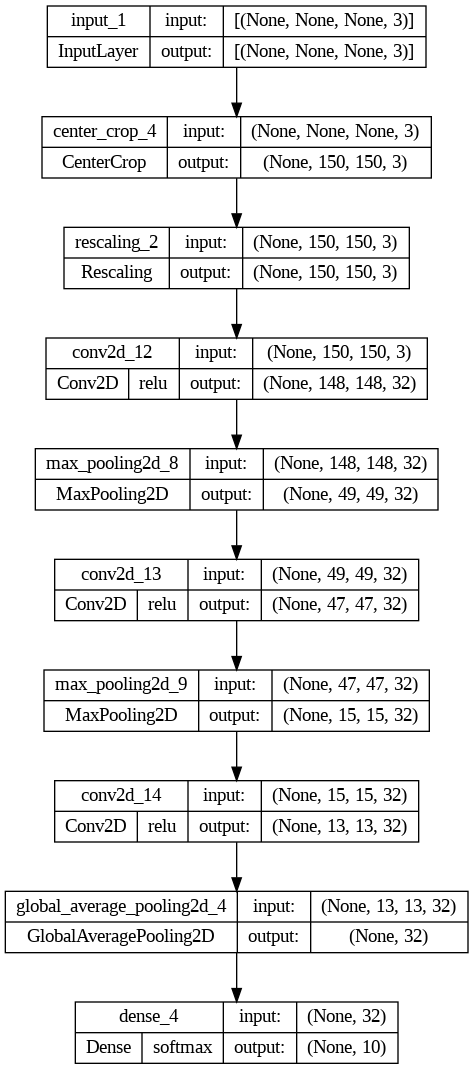

In [123]:
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, show_trainable=False)

In [125]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=keras.losses.CategoricalCrossentropy())
#OR
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

### Passing validation data to fit()

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
history = model.fit(dataset, epochs=1, validation_data=val_dataset)

### Using fit() with a custom training step

In [128]:
class CustomModel(keras.Model):
  def train_step(self, data):
    # Unpack the data. Its structure depends on your model and
    # on what you pass to `fit()`.
    x, y = data
    with tf.GradientTape() as tape:
      y_pred = self(x, training=True)  # Forward pass
      # Compute the loss value
      # (the loss function is configured in `compile()`)
      loss = self.compiled_loss(y, y_pred,
                                regularization_losses=self.losses)
    # Compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    # Update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    # Update metrics (includes the metric that tracks the loss)
    self.compiled_metrics.update_state(y, y_pred)
    # Return a dict mapping metric names to current value
    return {m.name: m.result() for m in self.metrics}

# Construct and compile an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=[...])

# Just use `fit` as usual
model.fit(dataset, epochs=3)

### Debugging your model with eager execution

In [ ]:
model.compile(optimizer='adam', loss='mse', run_eagerly=True)

### Keras Tuner For Hyperparameter Tuning

In [130]:
def build_model(hp):
    inputs = keras.Input(shape=(784,))
    x = layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),activation='relu')(inputs)
    outputs = layers.Dense(10, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [134]:
# !pip install keras-tuner --upgrade
import keras_tuner

tuner = keras_tuner.tuners.Hyperband(
  build_model,
  objective='val_loss',
  max_epochs=100,
  # max_trials=200,
  executions_per_trial=2,
  directory='my_dir')

tuner.search(dataset, validation_data=val_dataset)

In [135]:
models = tuner.get_best_models(num_models=2)

In [ ]:
tuner.results_summary()

In [136]:
encoder_input = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 conv2d_16 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 6, 6, 32)          9248      
                                                                 
 conv2d_18 (Conv2D)          (None, 4, 4, 16)          4624      
                                                           

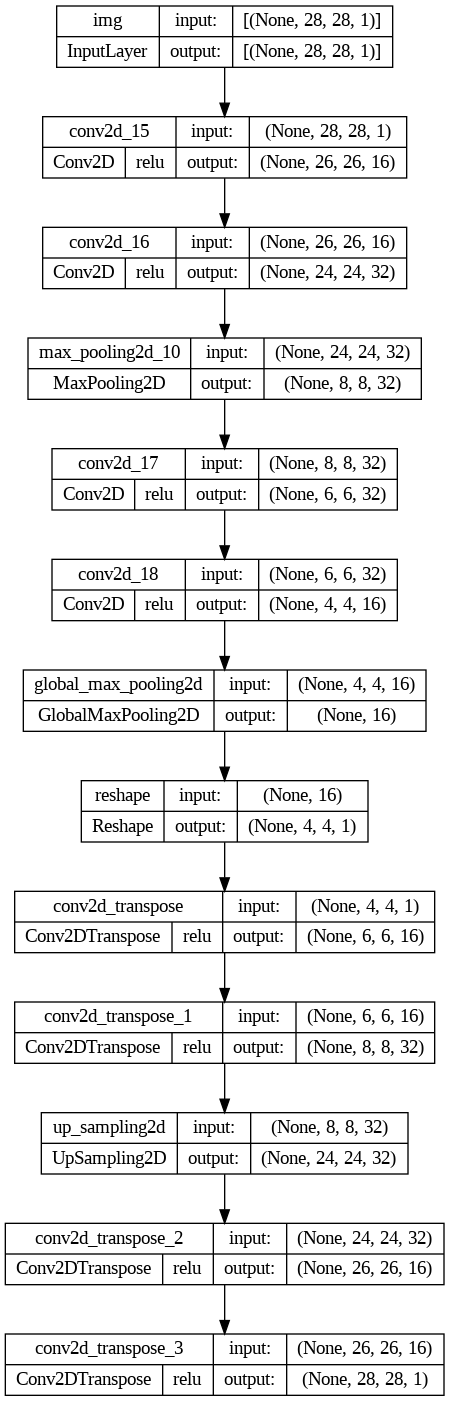

In [138]:
keras.utils.plot_model(autoencoder, show_shapes=True, show_layer_activations=True, show_trainable=False)

In [139]:
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 original_img (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 conv2d_20 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 6, 6, 32)          9248      
                                                                 
 conv2d_22 (Conv2D)          (None, 4, 4, 16)          4624      
                                                           

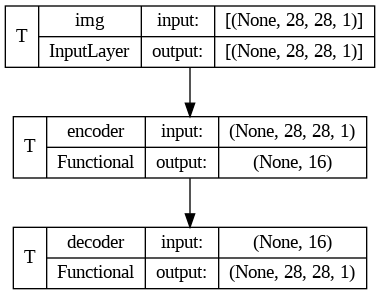

In [143]:
keras.utils.plot_model(autoencoder, show_shapes=True, show_layer_activations=True, show_trainable=True)

### Model Ensembling

In [144]:
def get_model():
    inputs = keras.Input(shape=(128,))
    outputs = layers.Dense(1)(inputs)
    return keras.Model(inputs, outputs)


model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)

outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

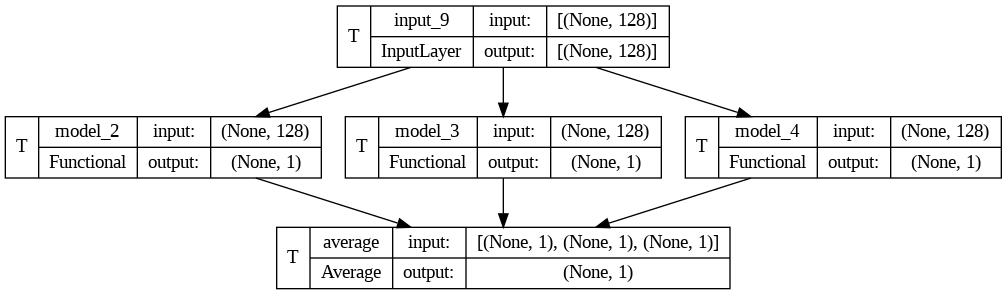

In [145]:
keras.utils.plot_model(ensemble_model, show_shapes=True, show_layer_activations=True, show_trainable=True)

### Manipulate complex graph topologies

Models with multiple inputs and outputs
The functional API makes it easy to manipulate multiple inputs and outputs. This cannot be handled with the Sequential API.

For example, if you're building a system for ranking customer issue tickets by priority and routing them to the correct department, then the model will have three inputs:

the title of the ticket (text input),
the text body of the ticket (text input), and
any tags added by the user (categorical input)
This model will have two outputs:

the priority score between 0 and 1 (scalar sigmoid output), and
the department that should handle the ticket (softmax output over the set of departments).
You can build this model in a few lines with the functional API:

In [146]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints

body_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints

tags_input = keras.Input(
    shape=(num_tags,), name="tags"
)  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)

# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)



# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)

# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)

# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)

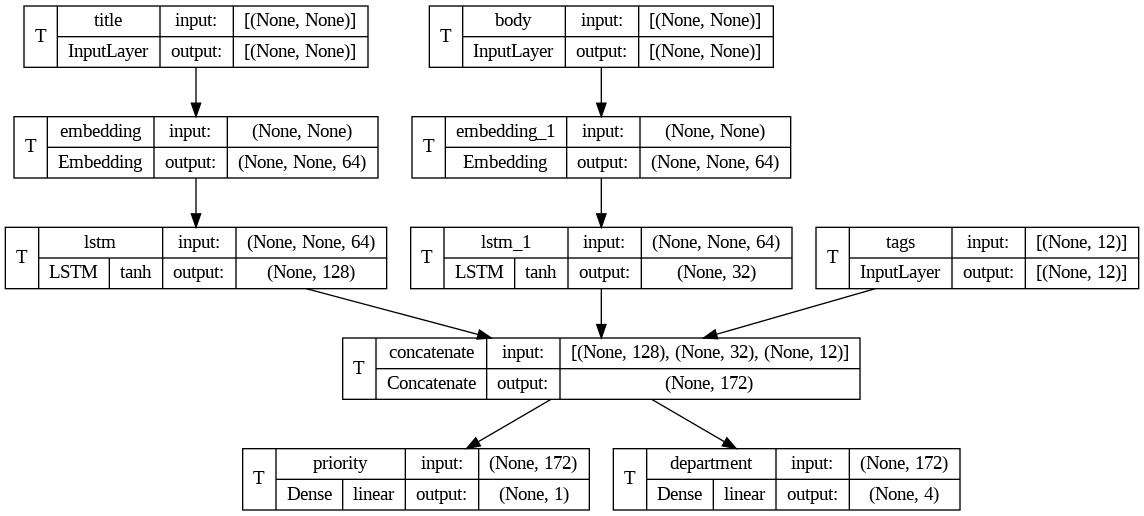

In [147]:
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, show_trainable=True)

In [148]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        keras.losses.BinaryCrossentropy(from_logits=True),
        keras.losses.CategoricalCrossentropy(from_logits=True),
    ],
    loss_weights=[1.0, 0.2],
)

In [149]:
#OR
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights={"priority": 1.0, "department": 0.2},
)

In [150]:
# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=2,
    batch_size=32,
)

Epoch 1/2
40/40 [==============================] - 6s 56ms/step - loss: 1.2675 - priority_loss: 0.7088 - department_loss: 2.7936
Epoch 2/2
40/40 [==============================] - 3s 80ms/step - loss: 1.2789 - priority_loss: 0.7008 - department_loss: 2.8908


### ResNet model

In [158]:
inputs = keras.Input(shape=(32, 32, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
# model.summary()

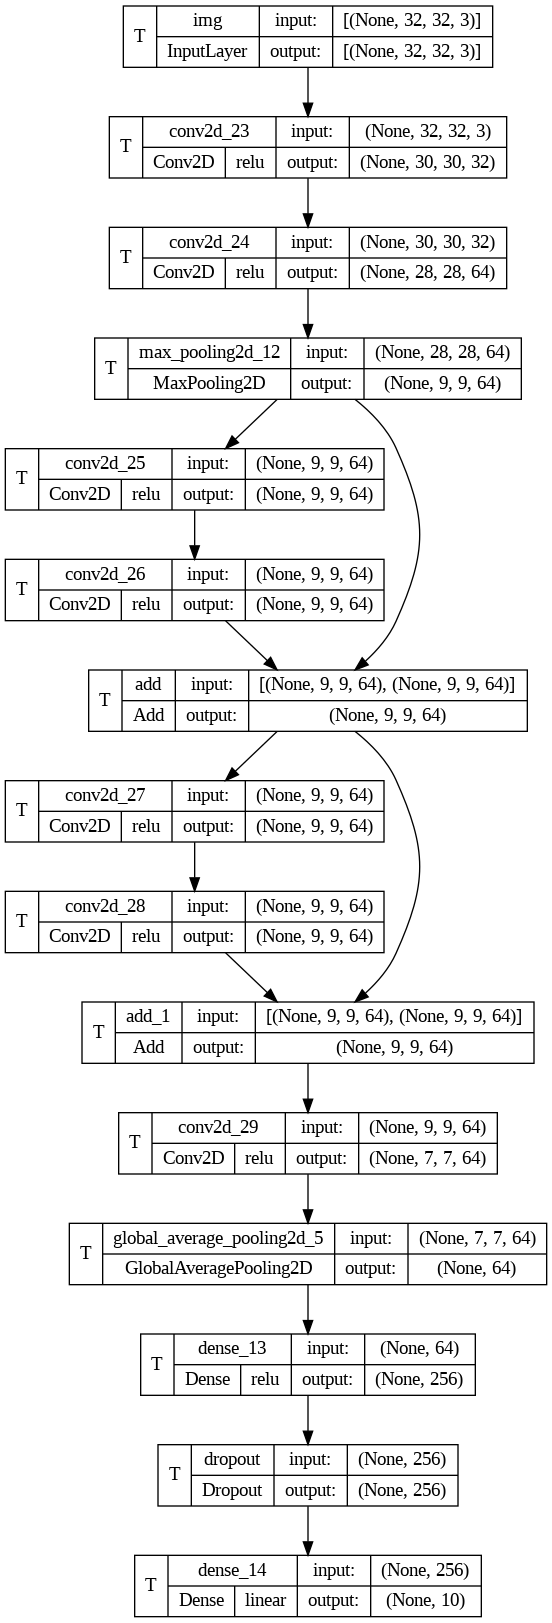

In [157]:
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, show_trainable=True)

In [161]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["acc"],
)
# We restrict the data to the first 1000 samples so as to limit execution time
# on Colab. Try to train on the entire dataset until convergence!
model.fit(x_train[:1000], y_train[:1000], batch_size=64, epochs=1, validation_split=0.2)

13/13 [==============================] - 15s 788ms/step - loss: 2.1094 - acc: 0.2550 - val_loss: 1.8085 - val_acc: 0.2600


### Shared Layers

In [162]:
# Embedding for 1000 unique words mapped to 128-dimensional vectors
shared_embedding = layers.Embedding(1000, 128)

# Variable-length sequence of integers
text_input_a = keras.Input(shape=(None,), dtype="int32")

# Variable-length sequence of integers
text_input_b = keras.Input(shape=(None,), dtype="int32")

# Reuse the same layer to encode both inputs
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)